In [1]:
%load_ext autoreload


In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats, signal
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


Matplotlib Version: 3.6.3


In [3]:
def radial_averaging_series(power2D, qx, qy, min_bin=0.001, max_bin=1, bin_width=0.001):
    """
    Perform radial averaging over multiple frames in a time series. 

    Radially average the power spectrum to obtain values. Notably the natural frequency unit
    of this function is A^-1.

    Args:
        power2D (numpy.array((M,N,N))): Power spectrum
        mc (_type_): Membrane curvature object with metadata
        min_bin (float, optional): Minimum bin value. Defaults to 0.001.
        max_bin (int, optional): Maximum bin value. Defaults to 1.
        bin_width (float, optional): Bin width. Defaults to 0.001.

    Returns:
        tuple: Binned power spectra
    """

    if not len(power2D.shape) == 3:
        raise RuntimeError("Expected time series of 2D power")

    x, y = np.meshgrid(qx,qy)  # A^-1
    r = np.sqrt(x**2 + y**2)
    bins = np.arange(min_bin, max_bin, bin_width)

    digitized = np.digitize(r, bins)
    bc = np.array(
        [
            r[digitized == i].mean() if np.count_nonzero(digitized == i) else np.NAN
            for i in range(1, len(bins))
        ]
    )

    first_iter = True

    spectra = None

    for i, frame in tqdm(enumerate(power2D), total=len(power2D)):
        bm = np.array(
            [
                frame[digitized == i].mean()
                if np.count_nonzero(digitized == i)
                else np.NAN
                for i in range(1, len(bins))
            ]
        )

        if i == 0:
            bin_centers = bc[np.isfinite(bm)]
            bin_means = bm[np.isfinite(bm)]
            spectra = np.zeros((power2D.shape[0], len(bin_means)))
            spectra[i] = bin_means
        else:
            spectra[i] = bm[np.isfinite(bm)]
    return (bin_centers, spectra)


In [4]:
with open("/u2/ctlee/mito_lipidomics_scratch/analysis/1_vbt/membrane_curvature_2nm.pickle", "rb") as handle:
    mc = pickle.load(handle)


MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'


In [5]:
kc_low_q = 0.4 / 10  # A^-1

def fit_kc_from_power(
    power2D, mc=None, threshold=0.03, min_bin=0.001, max_bin=1, bin_width=0.001
):
    spectra = radial_averaging(
        power2D, mc, min_bin=min_bin, max_bin=max_bin, bin_width=bin_width
    )
    mask = spectra[:, 0] < threshold
    spectra_cut = spectra[mask, :]

    return 1.0 / spectra_cut[:, 2].mean()


In [6]:
spectra = radial_averaging_series(mc.results.height_power_spectrum, mc.qx, mc.qy, min_bin=0.001, max_bin=1, bin_width=0.001)
qfour_spectra = np.power(spectra[0], 4) * spectra[1]


  0%|          | 0/10001 [00:00<?, ?it/s]

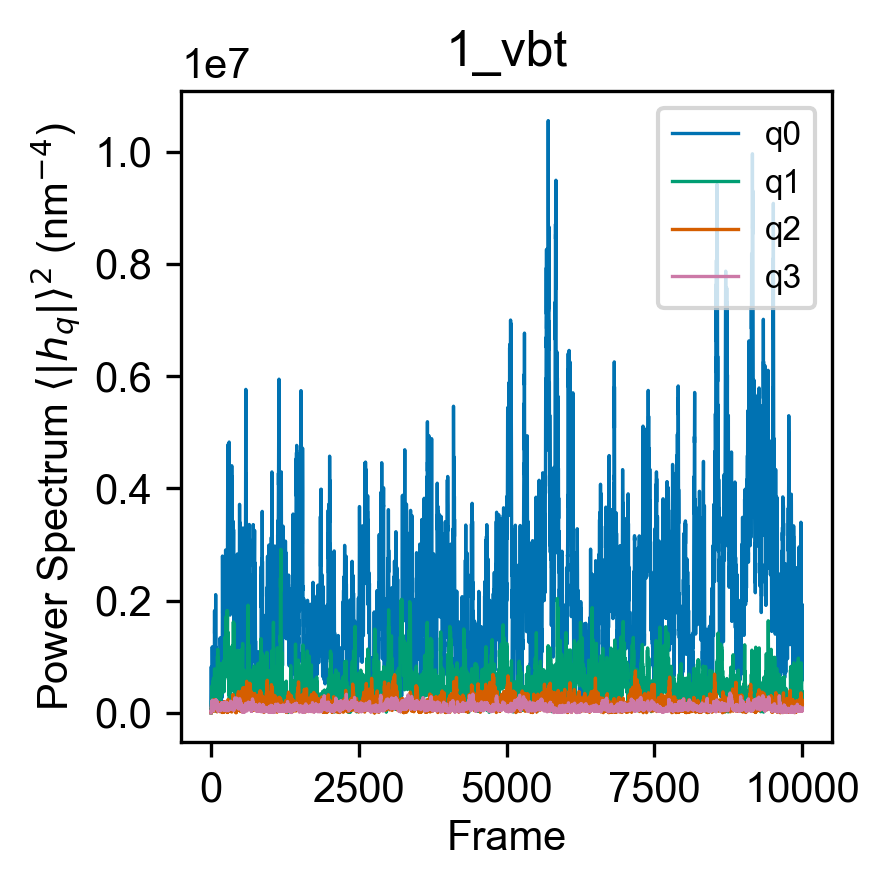

In [7]:
show_figs = True
curr_fig_path = Path("Figures/power_timeseries")
curr_fig_path.mkdir(parents=True, exist_ok=True)


fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

for i in range(0, 4):
    ax.plot(
        range(len(spectra[1][:, i])),
        spectra[1][:, i],
        linewidth=NORMAL_LINE,
        label=f"q{i}",
    )
    
    # plot q^4*h_q instead
    # ax.plot(
    #     range(len(spectra[sim][1][:, i])),
    #     np.power(spectra[sim][0][i],4)*spectra[sim][1][:, i],
    #     linewidth=NORMAL_LINE,
    #     label=f"q{i}",
    # )

ax.set_xlabel(r"Frame")
ax.set_ylabel(r"Power Spectrum $\langle|h_q|\rangle^2$ (nm$^{-4}$)")
ax.set_title(f"1_vbt")

ax.legend(loc="upper right")

# # Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# # Put a legend to the right of the current axis
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.savefig(curr_fig_path/f"1_vbt_power_timeseries.png", format="png")

if show_figs:
    plt.show()
    
fig.clear()
plt.close(fig)


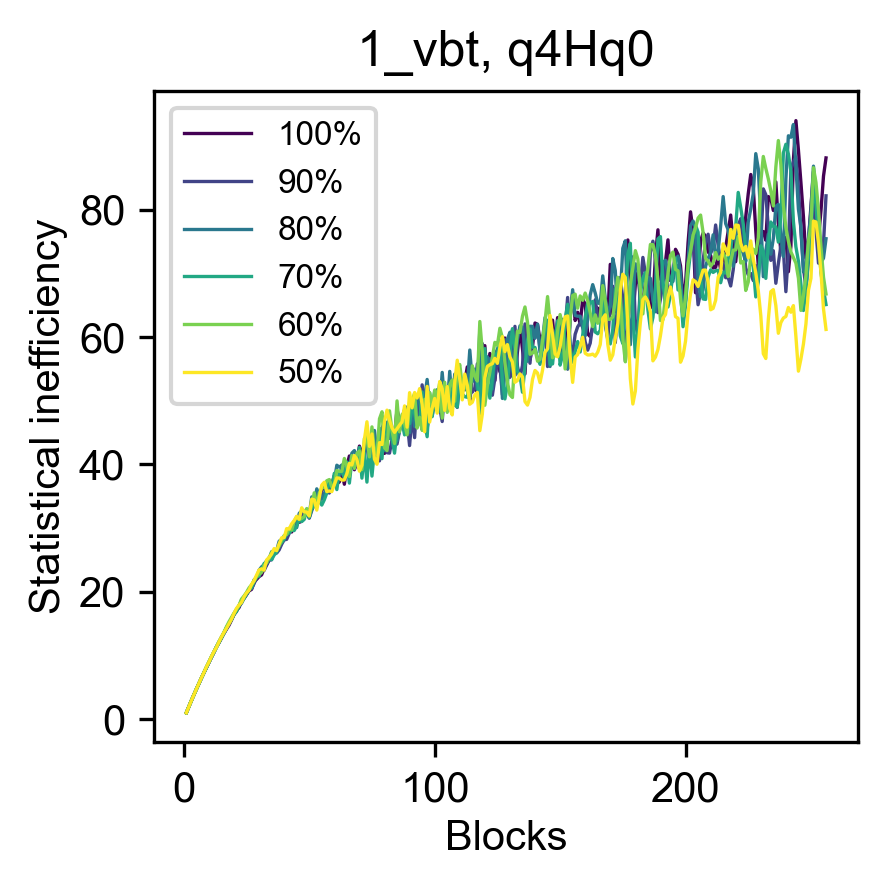

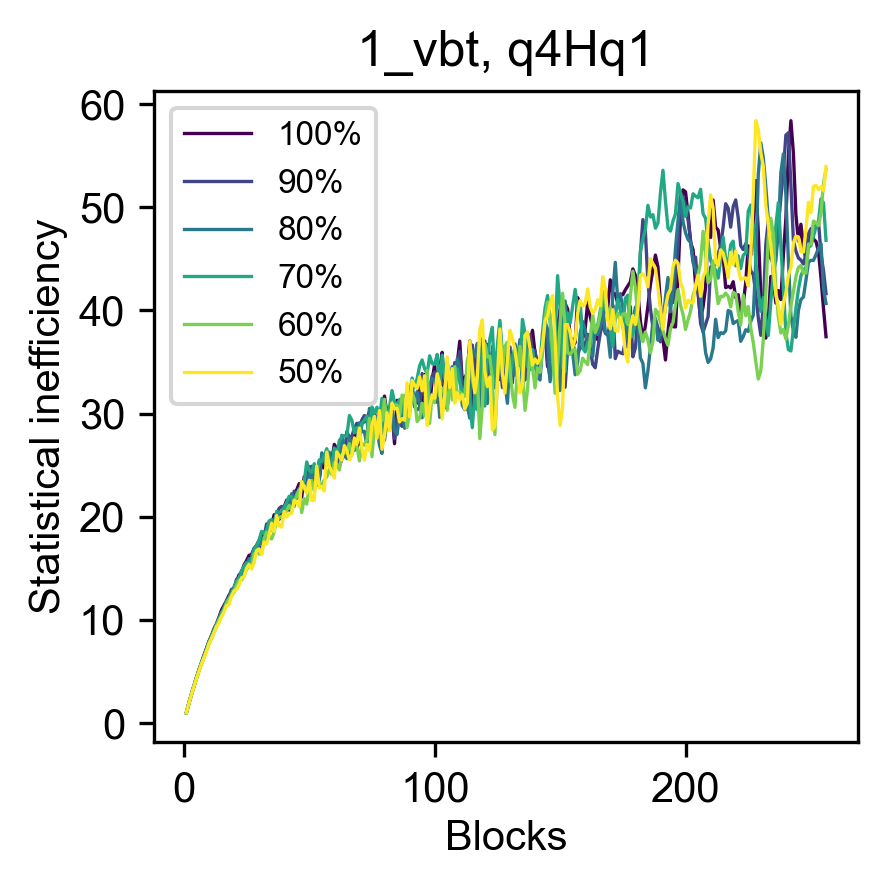

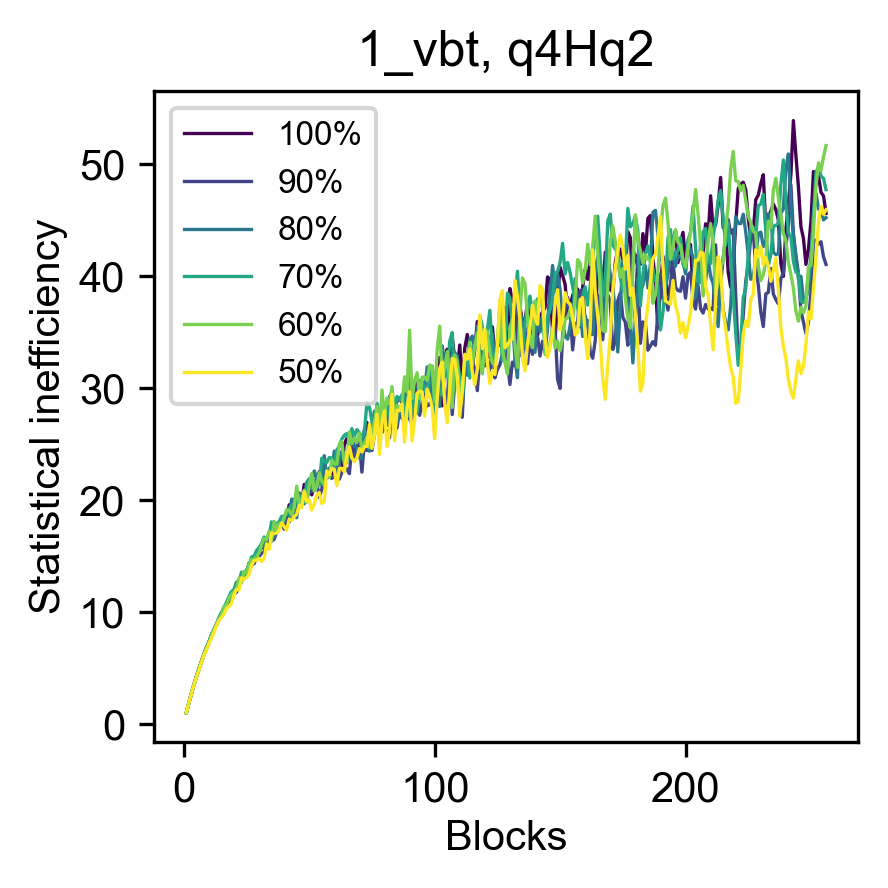

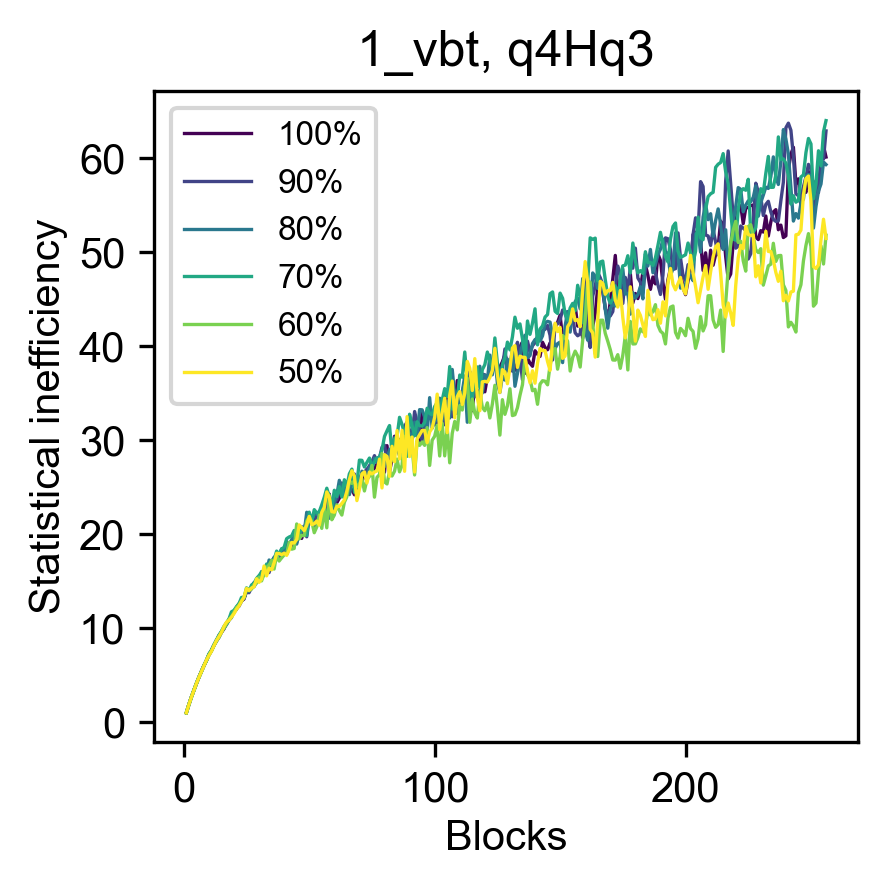

In [8]:
show_figs = True
curr_fig_path = Path("Figures/amplitude_si")
curr_fig_path.mkdir(parents=True, exist_ok=True)

## COMPUTE STATISTICAL INEFFICIENCY OF WAVE NUMBERS UP TO max_q
max_q = 4
discards = np.arange(0, 60, 10)
blocks = np.arange(1, 2**8 + 1, 1)

cmap = mpl.cm.get_cmap("viridis")

for q in range(0, max_q):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,
    c = cmap(np.linspace(0, 1, len(discards)))

    _, _, si = util.statistical_inefficiency(
        qfour_spectra[:, q], blocks, discards
    )

    for d, discard in enumerate(discards):
        ax.plot(
            blocks,
            si[d],
            color=c[d],
            linewidth=NORMAL_LINE,
            label=f"{100-discard}%",
        )

    ax.set_xlabel(r"Blocks")
    ax.set_ylabel(r"Statistical inefficiency")
    ax.set_title(f"1_vbt, q4Hq{q}")
    ax.legend(loc="upper left")
    fig.tight_layout()

    # # Shrink current axis by 20%
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # # Put a legend to the right of the current axis
    # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    fig.savefig(curr_fig_path/f"1_vbt_q4Hq{q}.png", format="png")

    if show_figs:
        plt.show()
    fig.clear()
    plt.close(fig)


In [9]:
def correlation_time_sqrt(b, tau):
    ct = np.exp(-1 / tau)
    cb = np.exp(-b / tau)
    return np.sqrt((1 + ct) / (1 - ct) - (2 * ct) / b * (1 - cb) / np.power(1 - ct, 2))

def correlation_time(b, tau):
    ct = np.exp(-1 / tau)
    cb = np.exp(-b / tau)
    return (1 + ct) / (1 - ct) - (2 * ct) / b * (1 - cb) / np.power(1 - ct, 2)


In [10]:
# Discard first X% for all trajectories
discard = 10
blocks = np.arange(1, 2**9 + 1, 1)

block_var = {}
lp_block_sem = {}
block_mean = {}

max_q = sum(spectra[0] < kc_low_q)

block_mean = np.zeros((max_q, len(blocks)))
block_var = np.zeros((max_q, len(blocks)))
lp_block_sem = np.zeros((max_q, len(blocks)))

low_q_data = qfour_spectra[:, 0:max_q]
# low_q_data = spectra[sim][1][:, 0:max_q]

_, remainder = np.split(low_q_data, [int(discard / 100 * len(low_q_data))])

block_mean = util.nd_block_average(remainder, axis=0, func=np.mean, blocks=blocks)
block_var = util.nd_block_average(remainder, axis=0, func=partial(np.var, ddof=1), blocks=blocks)
lp_block_sem = util.nd_block_average(remainder, axis=0, func=partial(stats.sem, ddof=1), blocks=blocks)


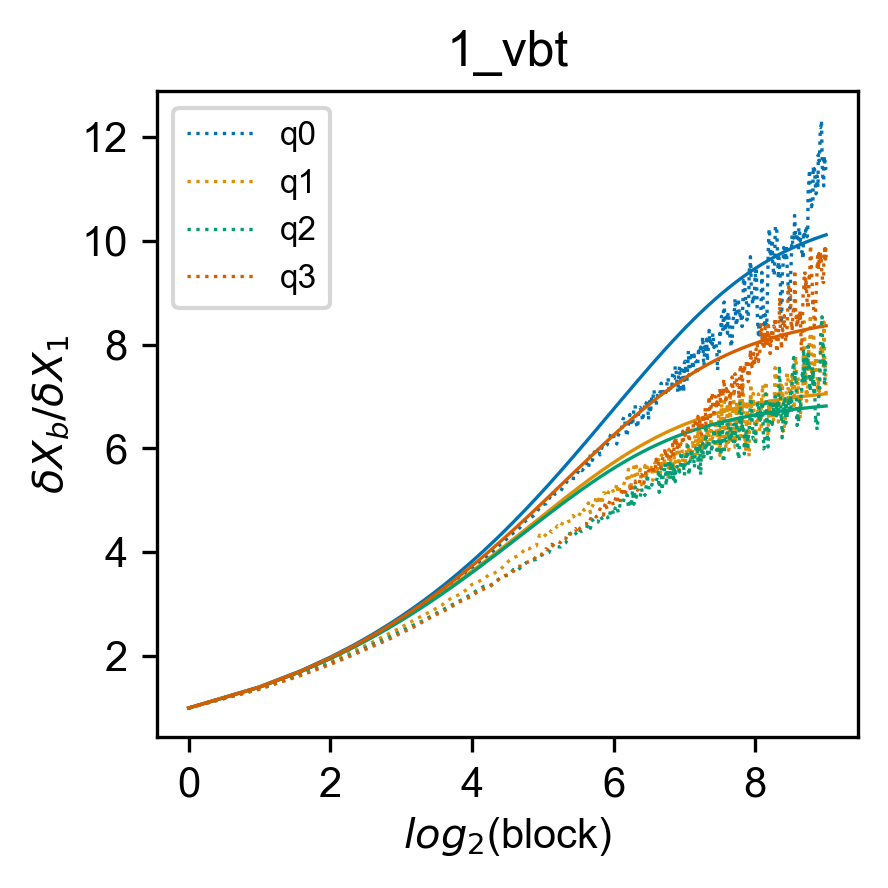

In [11]:
show_figs = True
curr_fig_path = Path("Figures/kc_block_error")
curr_fig_path.mkdir(parents=True, exist_ok=True)

corrected_mean_sem = {}

fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

corrected_mean_sem = np.empty((2, max_q))

for q in range(0, max_q):
    # Mean with block size 1
    corrected_mean_sem[0, q] = block_mean[q][0] 
    blocked_sem = lp_block_sem[q]
    popt, pcov = curve_fit(
        correlation_time_sqrt, blocks, blocked_sem / blocked_sem[0]
    )
    corrected_mean_sem[1, q] = blocked_sem[0]* np.sqrt(2*popt[0])
    
    ax.plot(
        np.log2(blocks),
        blocked_sem / blocked_sem[0],
        linewidth=NORMAL_LINE,
        label=f"q{q}",
        color=sns.color_palette("colorblind")[q],
        linestyle=":",
    )

    ax.plot(
        np.log2(blocks),
        [correlation_time_sqrt(block, popt) for block in blocks],
        linewidth=NORMAL_LINE,
        color=sns.color_palette("colorblind")[q],
    )

ax.set_xlabel(r"$log_2$(block)")
ax.set_ylabel(r"$\delta X_b/\delta X_1$")
ax.set_title(f"1_vbt")
ax.legend(loc="upper left")

fig.tight_layout()

fig.savefig(curr_fig_path/f"1_vbt_block_error.png", format="png")
fig.savefig(curr_fig_path/f"1_vbt_block_error.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


In [17]:
f_rvs = []

# Construct random Gaussian process for each wavenumber
for q in range(corrected_mean_sem.shape[1]):
    # print(corrected_mean_sem[0, i], corrected_mean_sem[1][i])
    r = stats.norm(
        loc=corrected_mean_sem[0, q], scale=corrected_mean_sem[1][q]
    )
    f_rvs.append(r.rvs)
# Run parametric bootstrap with random process
boot = util.parametric_bootstrap(f_rvs, n_samples=50000)

# Fit kcs to bootstrap samples
kcs = 1.0 / np.mean(boot, axis=0)
kc_mean_std = [np.mean(kcs), np.std(kcs)]

print(
    "1_vbt", kc_mean_std
)

kc_mean_std_all = np.load('kc_mean_std.npy', allow_pickle=True).item()
print("1    ", kc_mean_std_all[1])

print((kc_mean_std[0]-kc_mean_std_all[1][0])/kc_mean_std_all[1][0]*100, "% change")


1_vbt [8.964155154524486, 0.2526449903685156]
1     [7.515523563178702, 0.28538612846793077]
19.275191929982892 % change


/home/ctlee/.conda/envs/mda/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


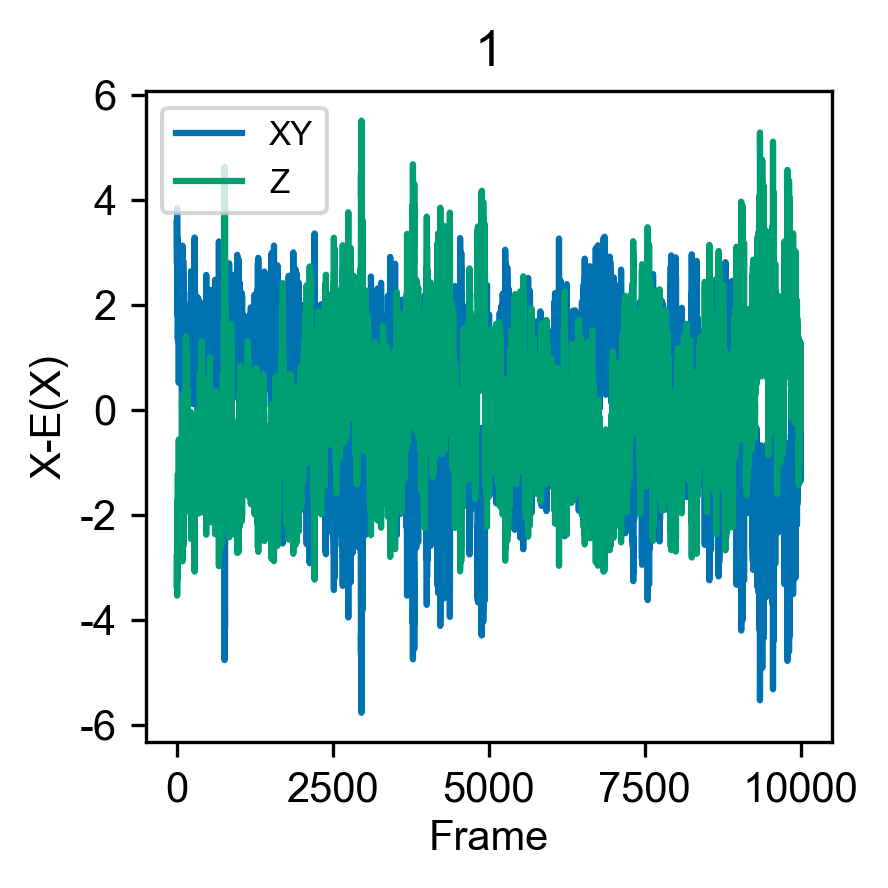

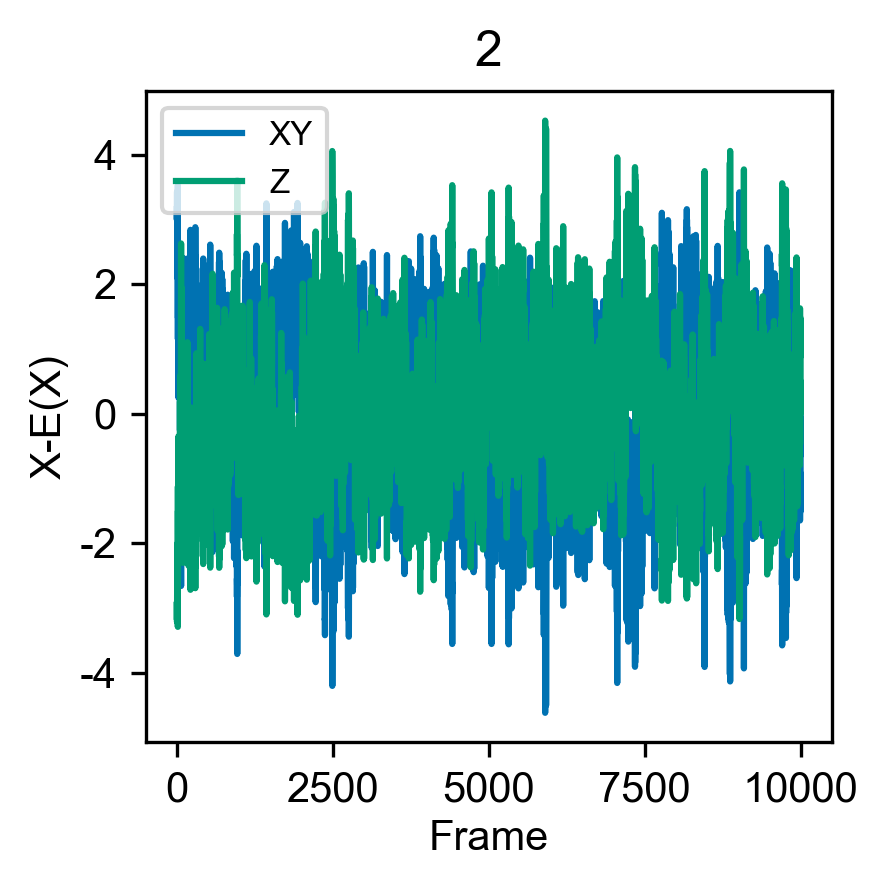

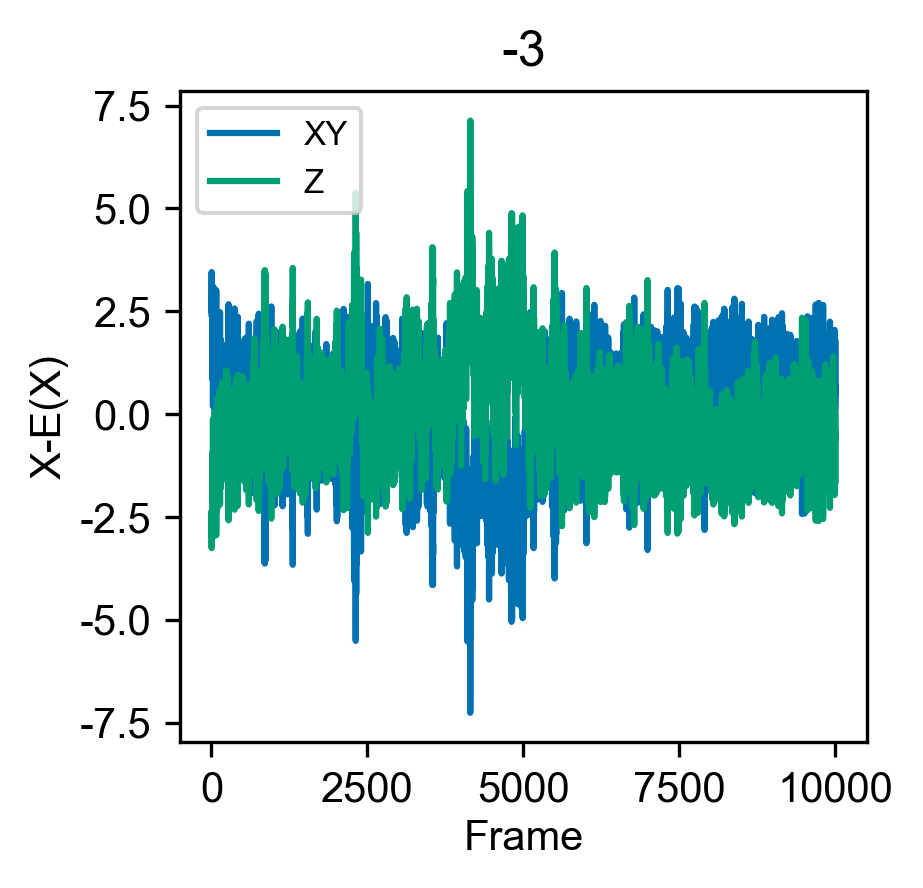

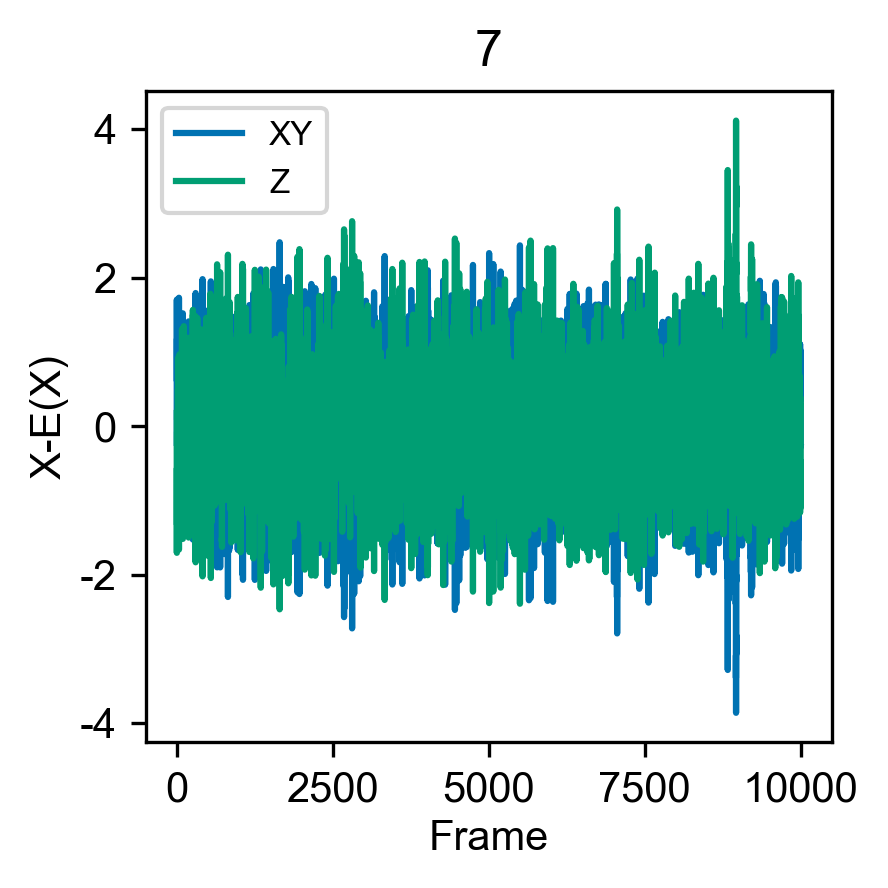

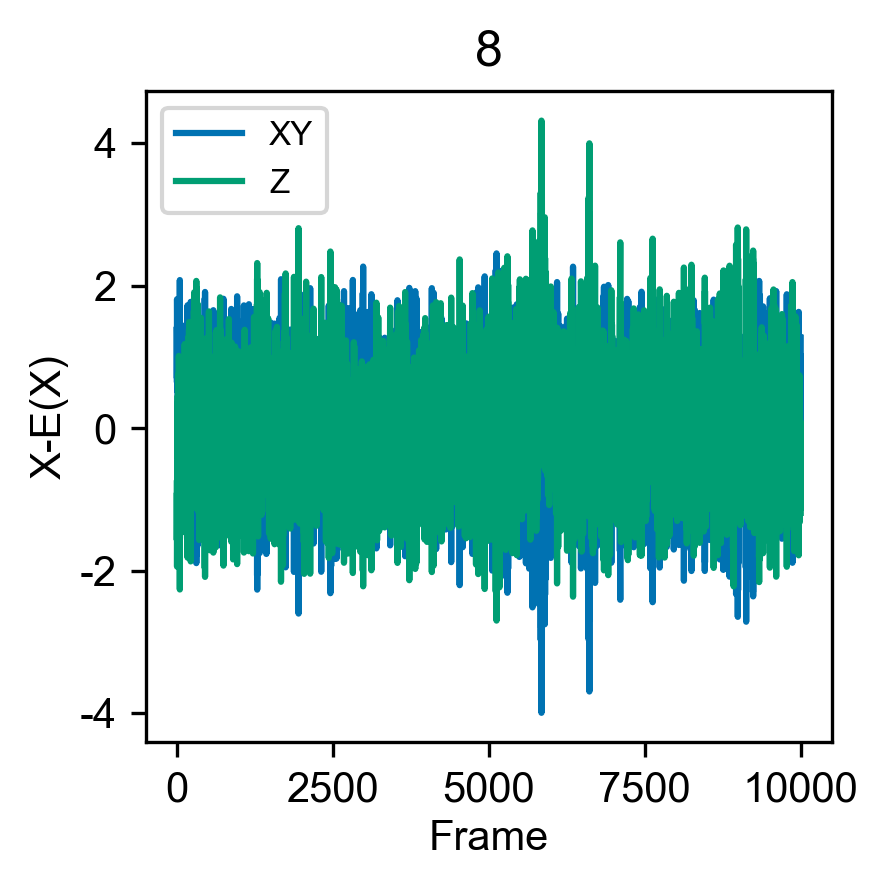

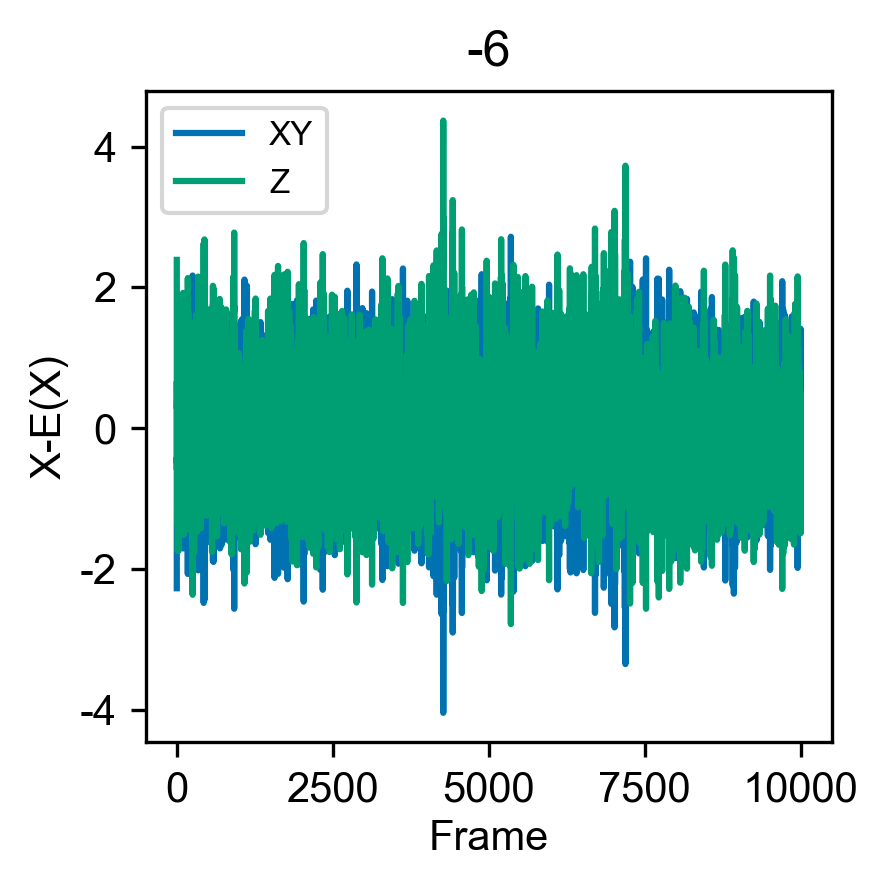

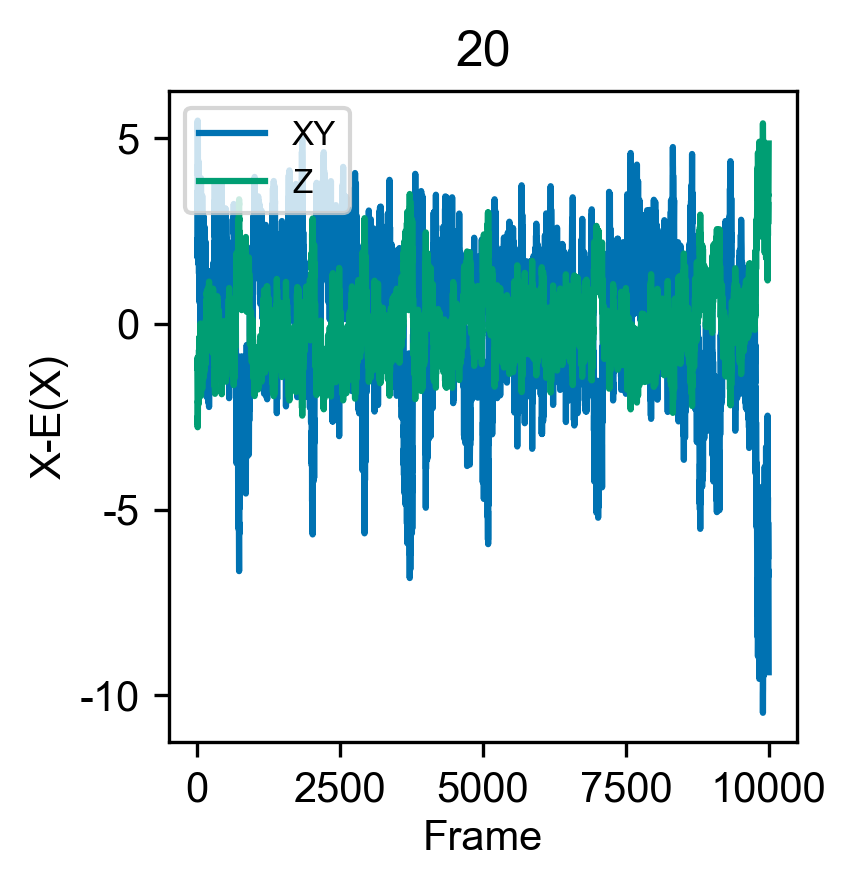

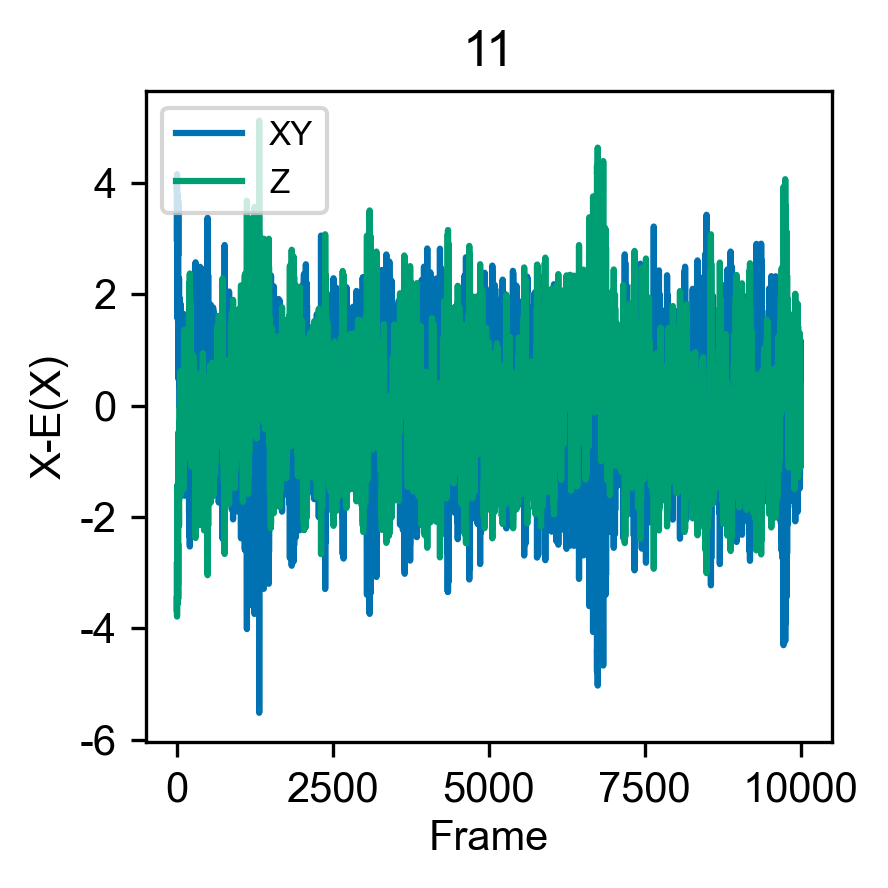

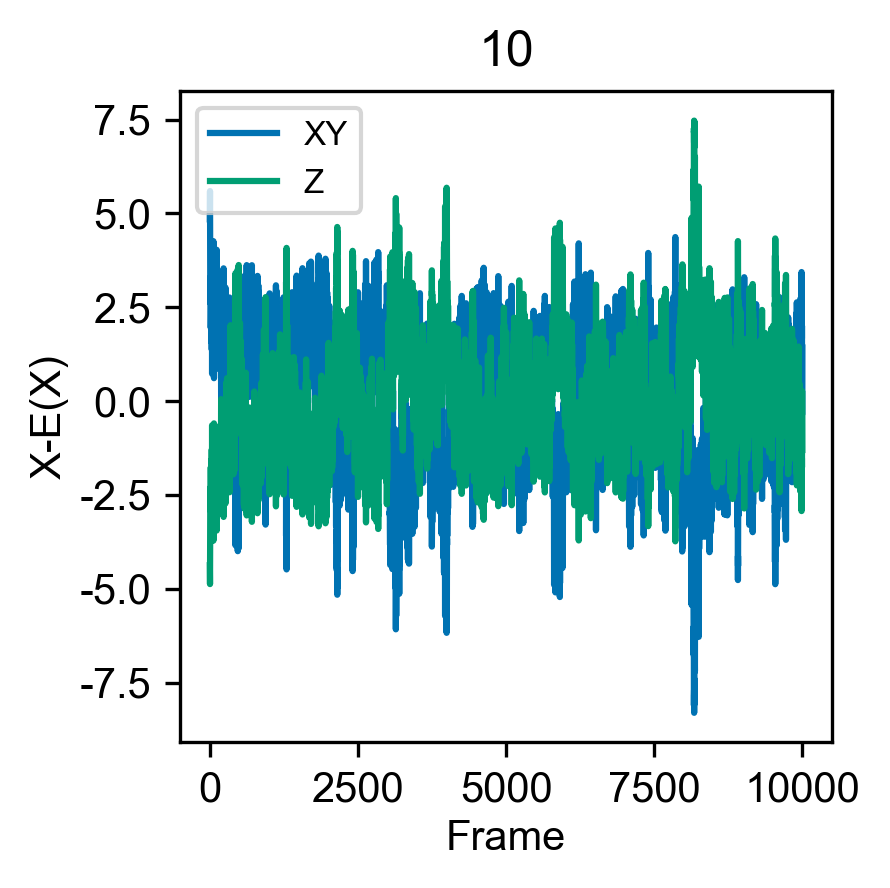

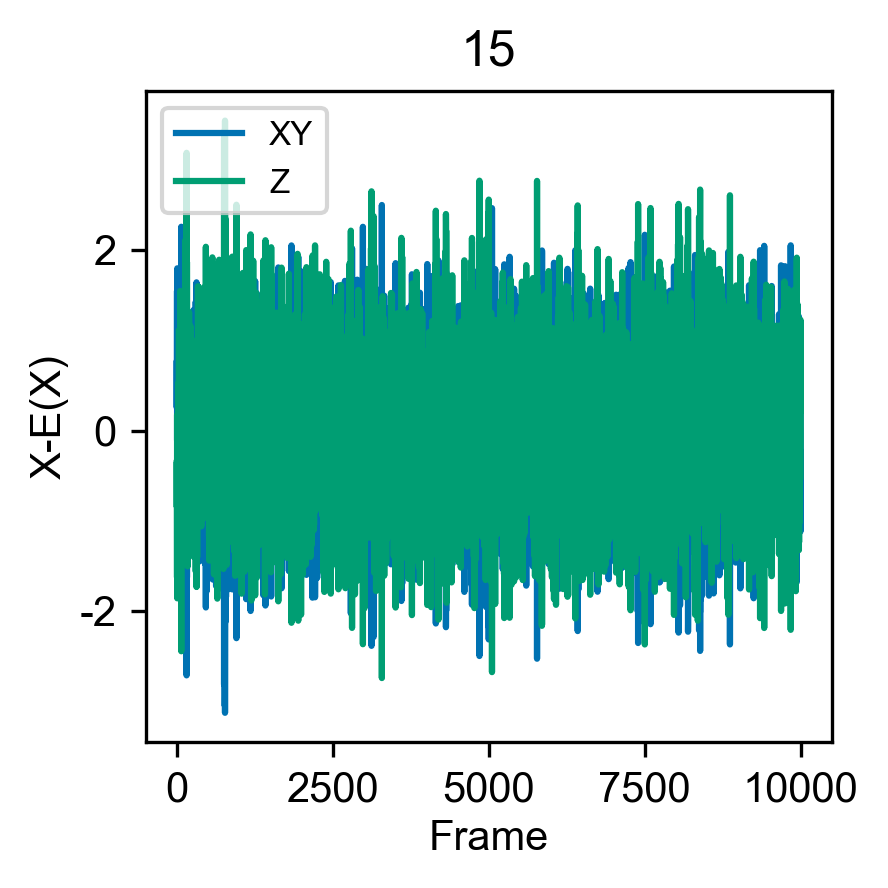

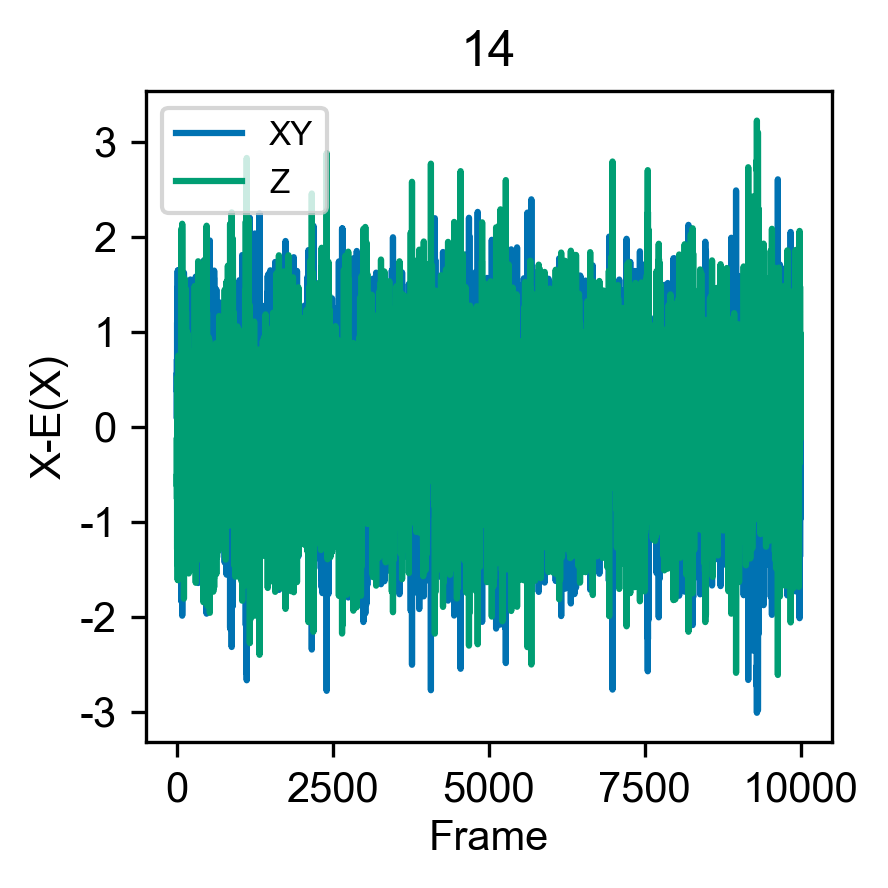

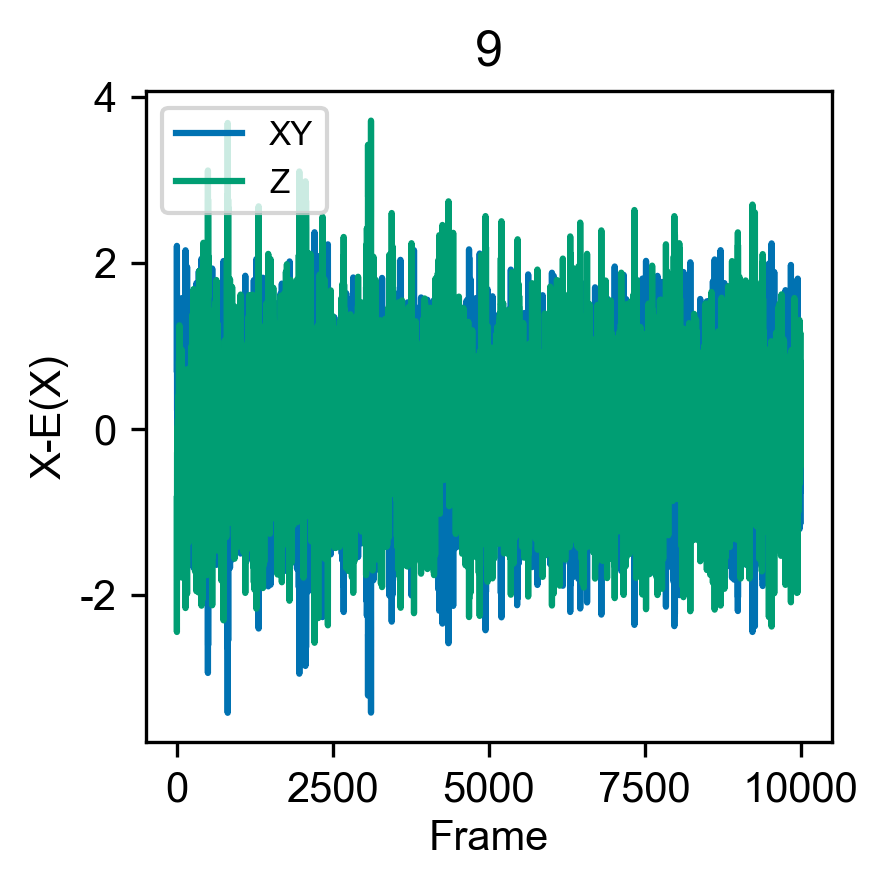

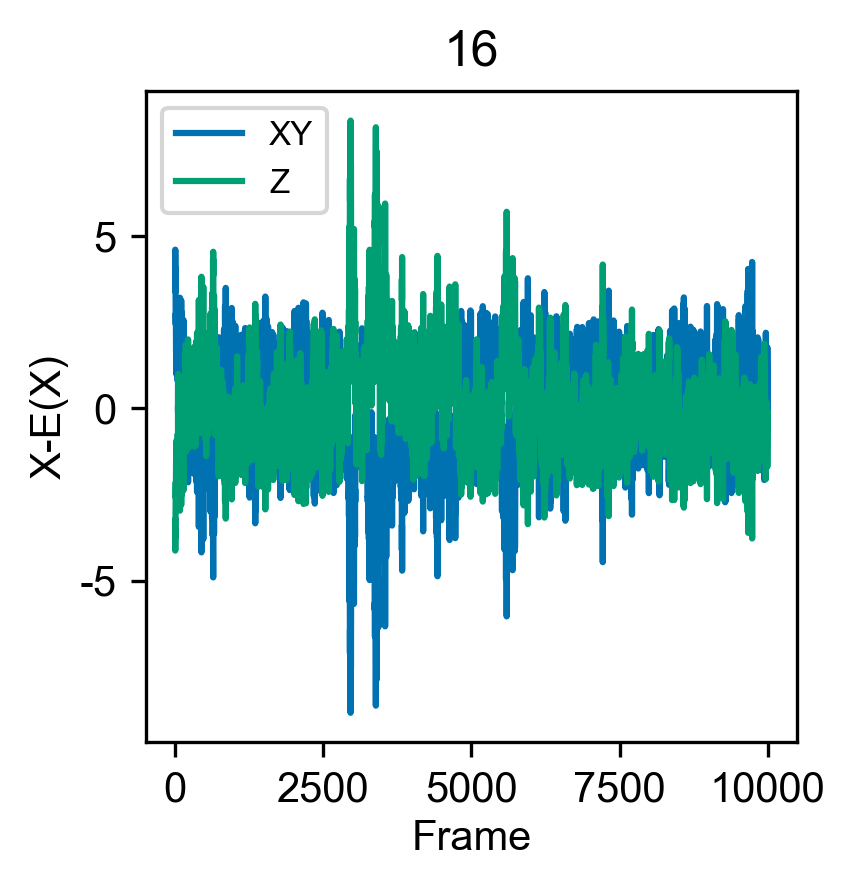

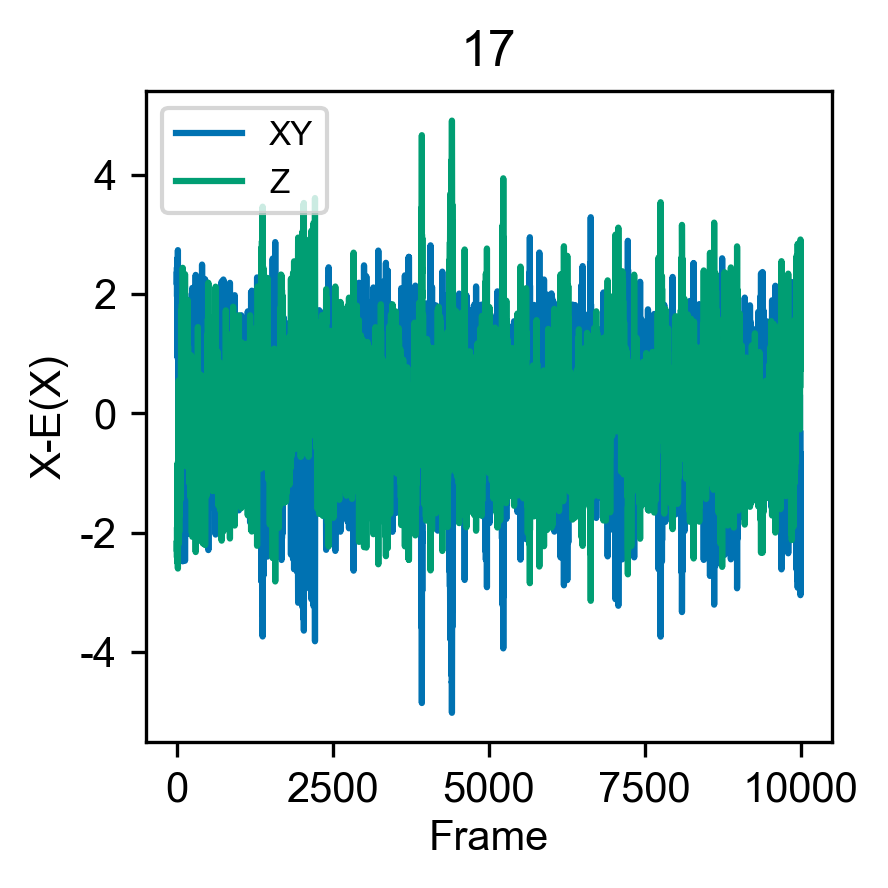

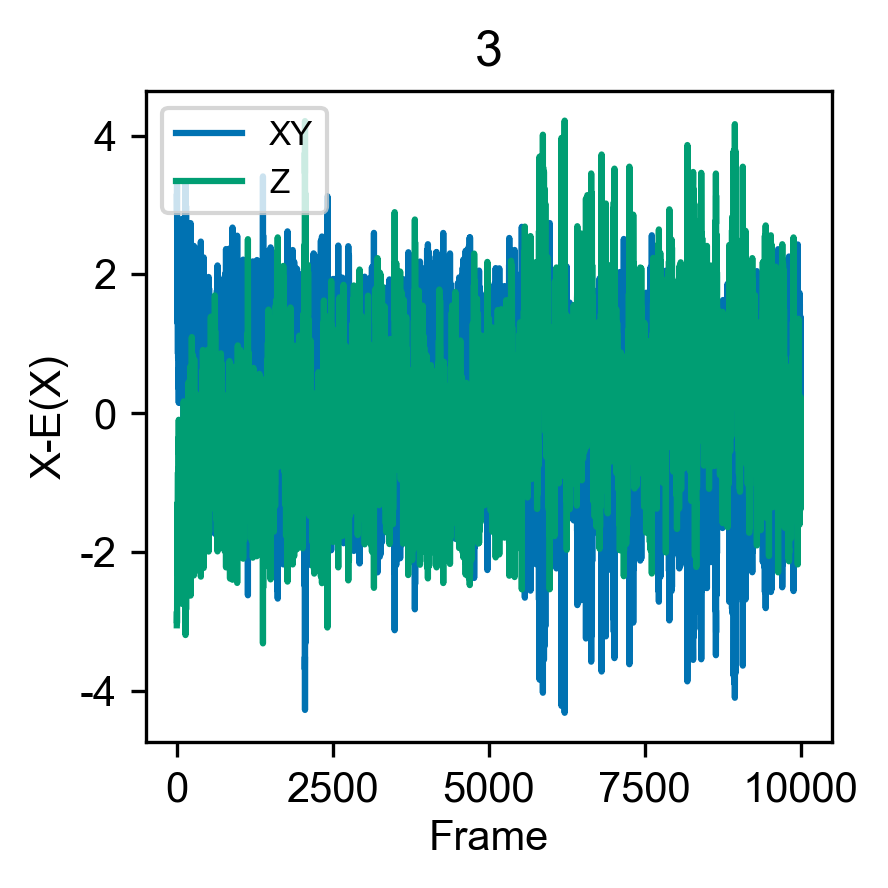

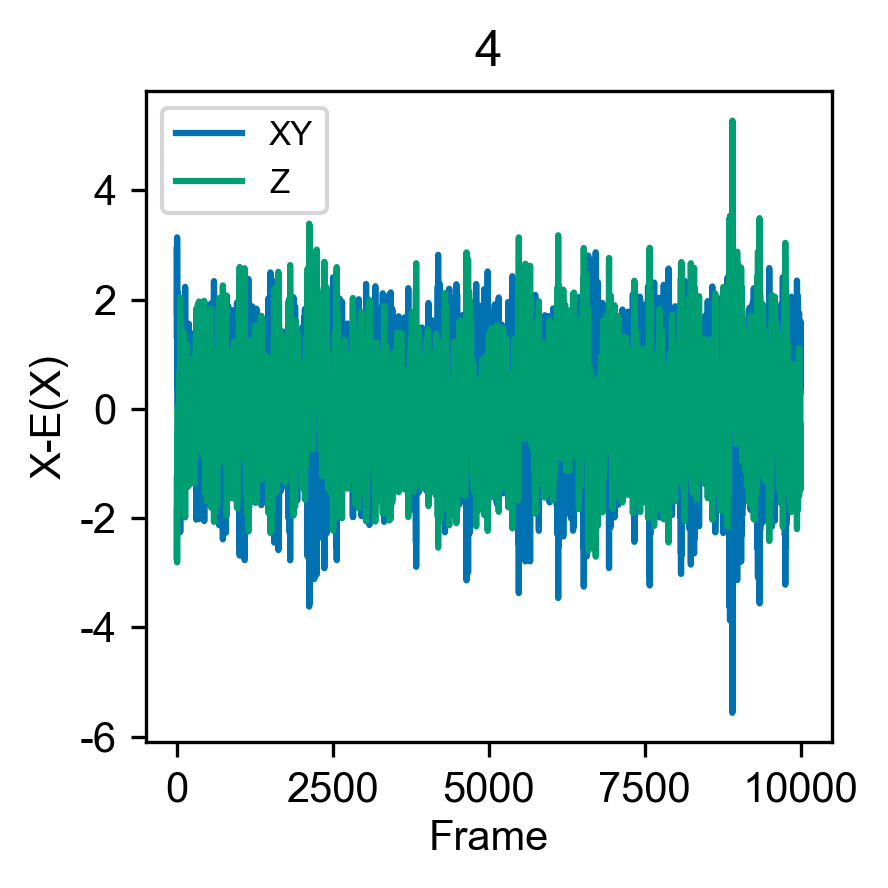

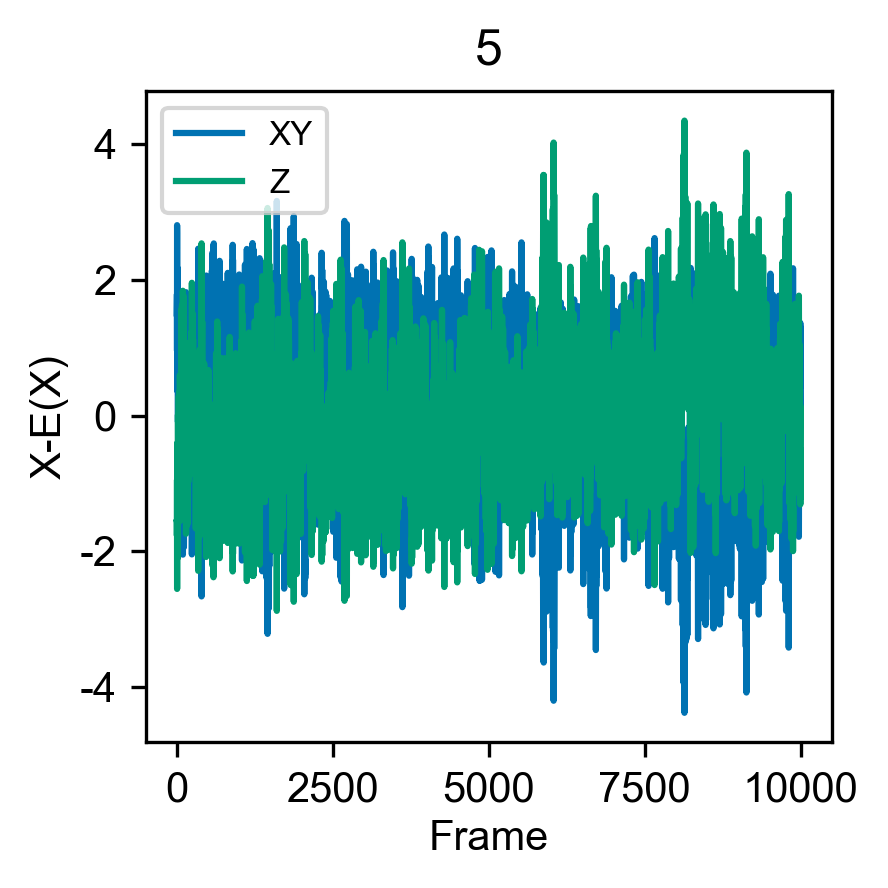

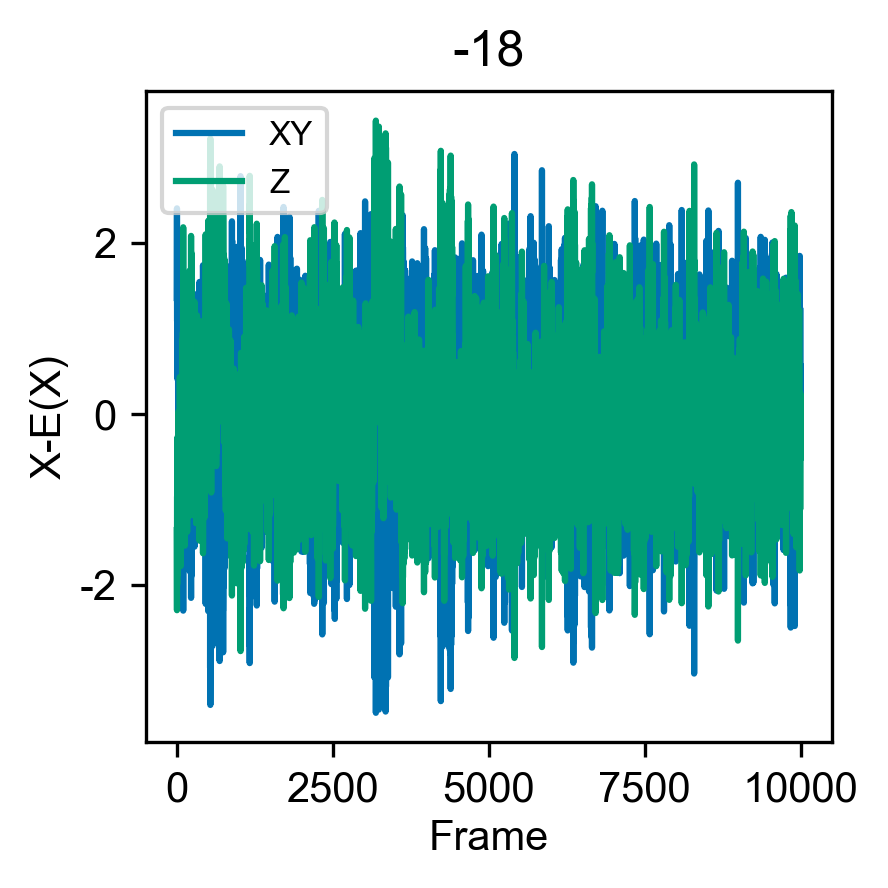

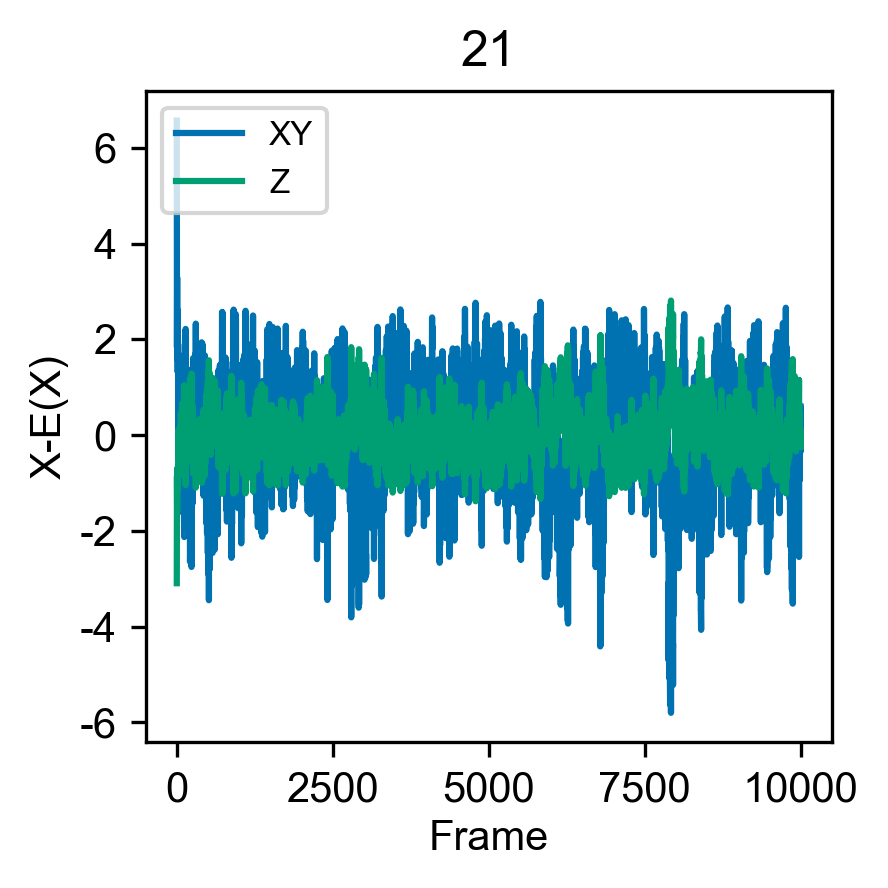

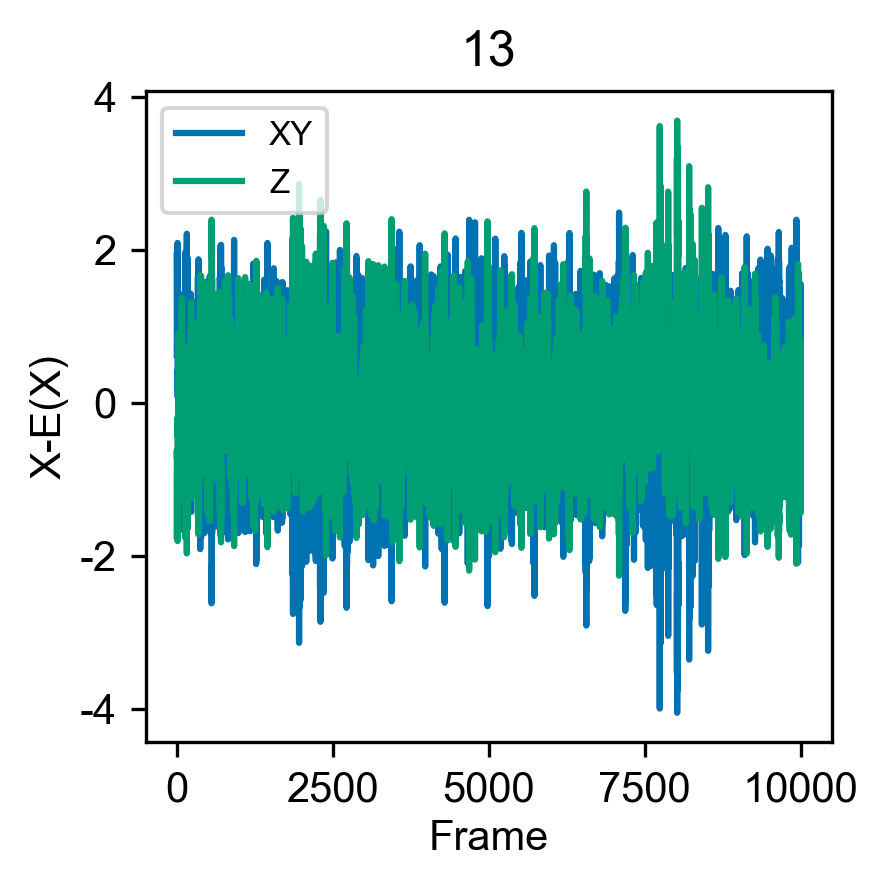

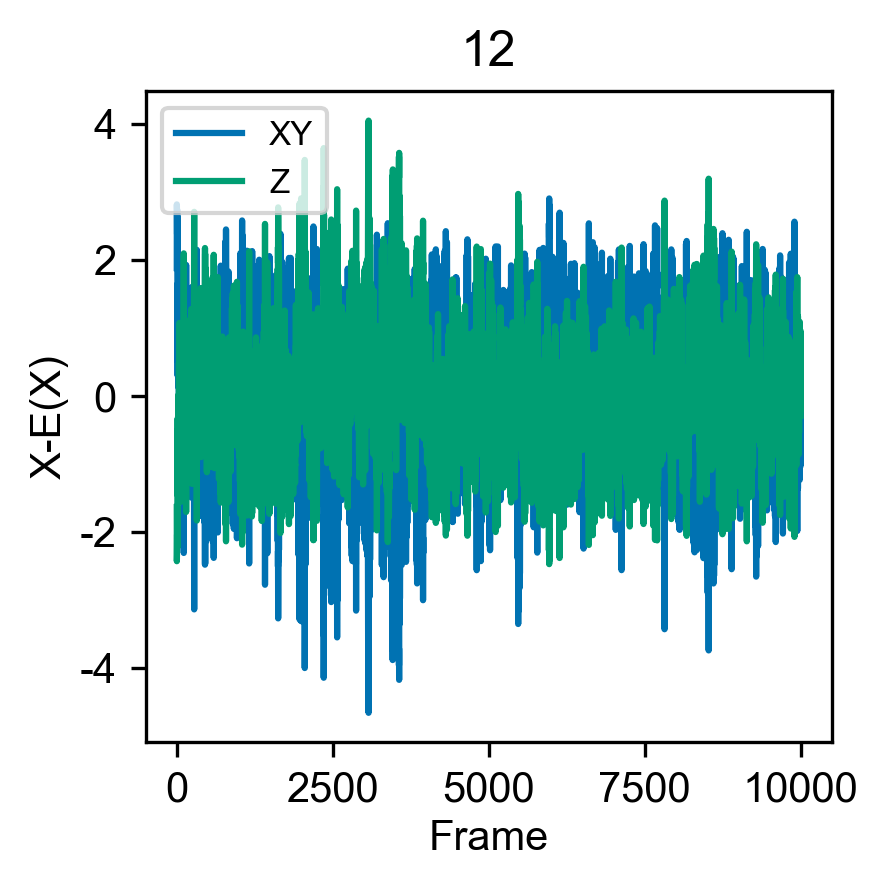

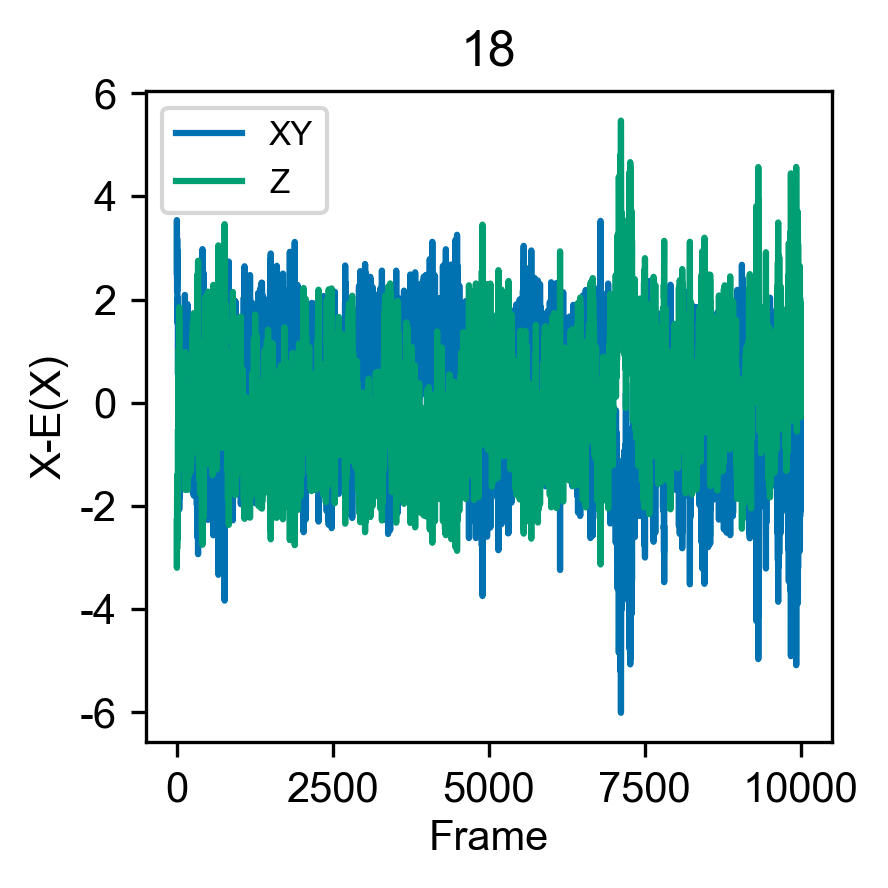

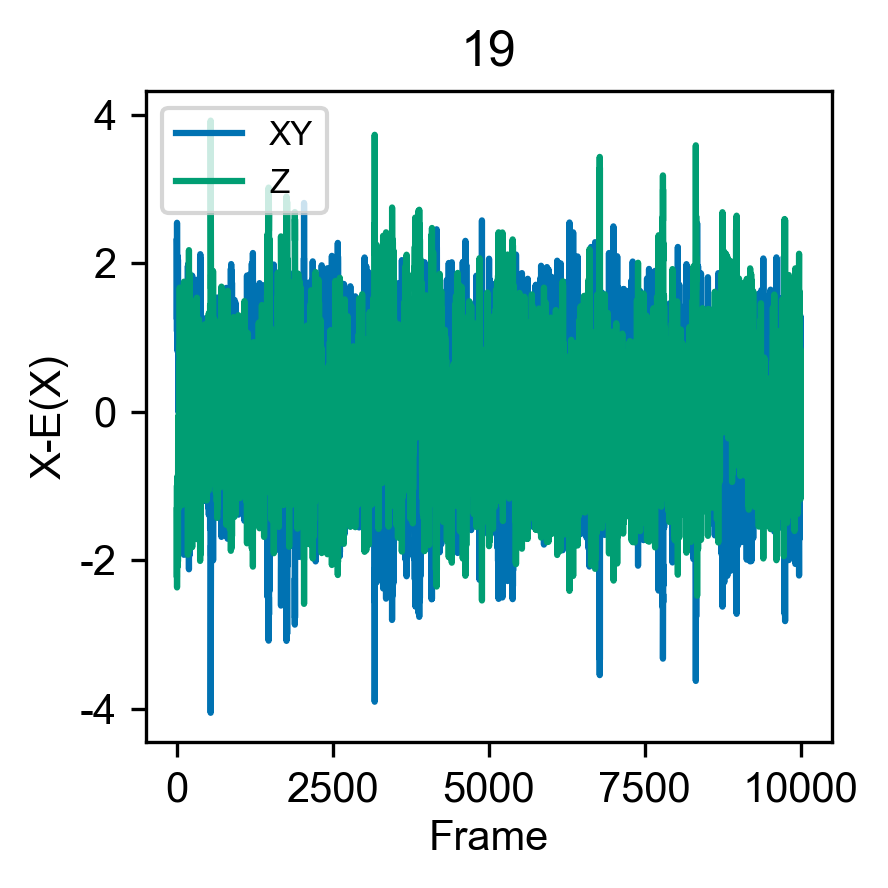

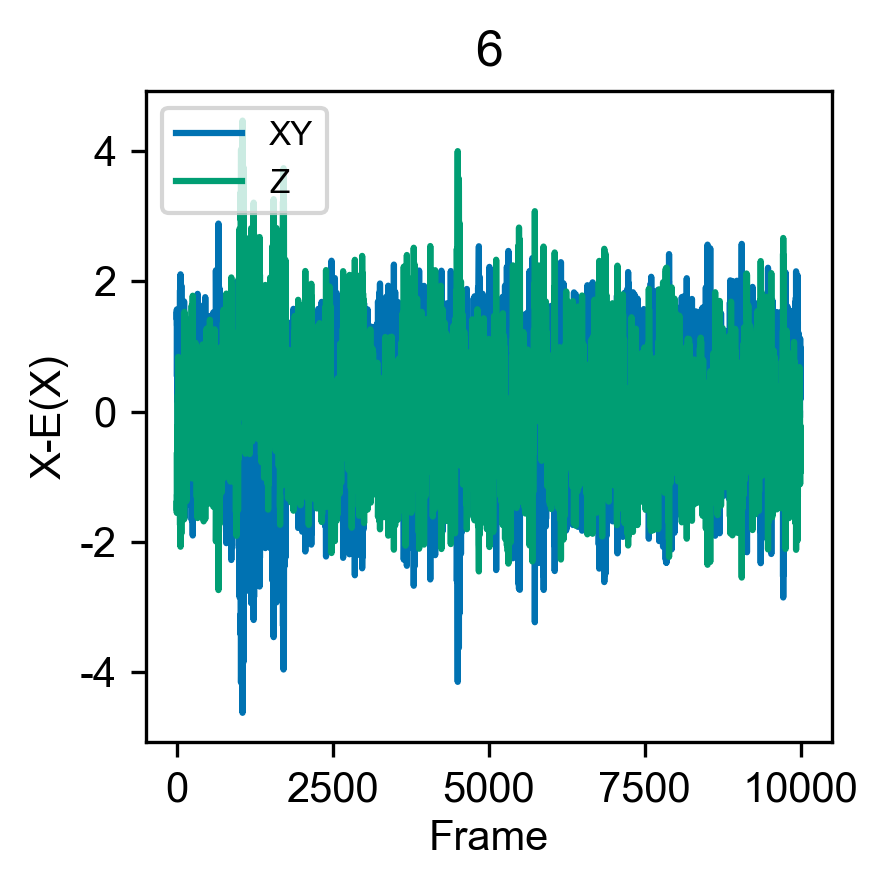

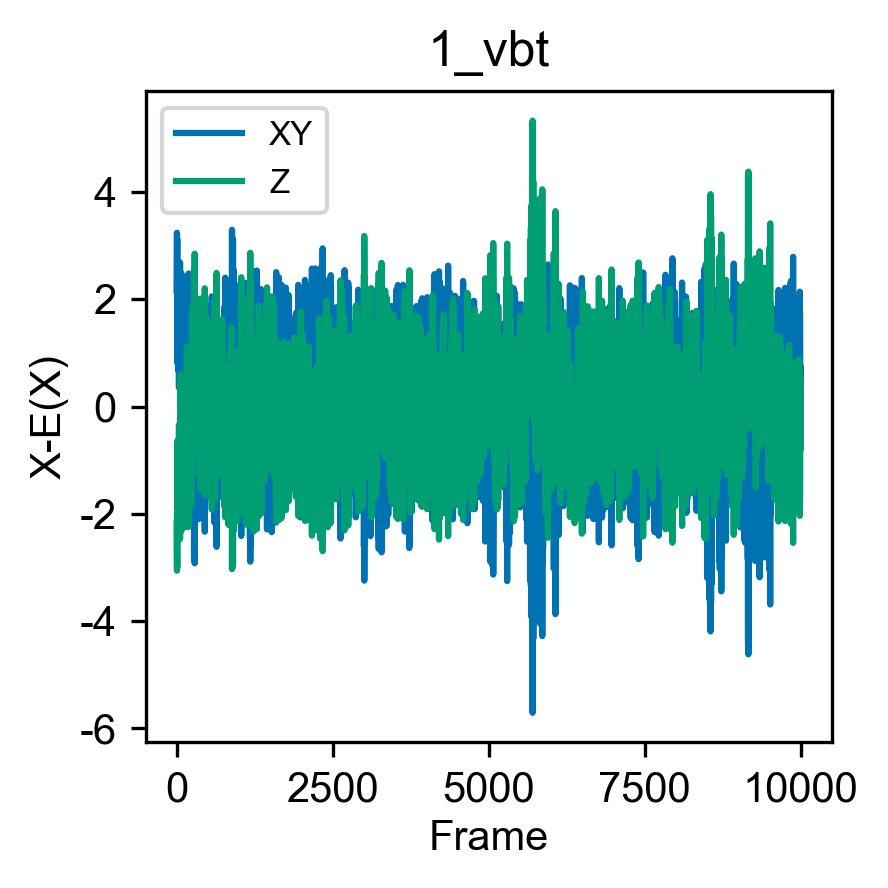

In [14]:
show_figs = True
curr_fig_path = Path("Figures/areas")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for sim in np.concatenate((util.simulations, ["1_vbt"])):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

    gro = util.analysis_path / f"{sim}/po4_only.gro"
    traj = util.analysis_path / f"{sim}/po4_all.xtc"

    u = MDAnalysis.Universe(gro, str(traj), refresh_offsets=True)

    nframes = len(u.trajectory)
    dims = np.array([[u.dimensions[0], u.dimensions[2]] for ts in u.trajectory])

    ax.plot(range(nframes), dims[:,0]-np.mean(dims[:,0]), label="XY")
    ax.plot(range(nframes), dims[:,1]-np.mean(dims[:,1]), label="Z")

    ax.set_xlabel(r"Frame")
    ax.set_ylabel(r"X-E(X)")
    if sim == "1_vbt":
        ax.set_title(f"1_vbt")
    else:
        ax.set_title(f"{util.sim_to_final_index[int(sim)]}")
    ax.legend(loc="upper left")

    fig.tight_layout()
    if sim == "1_vbt":
        fig.savefig(curr_fig_path/f"1_vbt_area.png", format="png")
        fig.savefig(curr_fig_path/f"1_vbt_area.pdf", format="pdf")
    else:
        fig.savefig(curr_fig_path/f"{util.sim_to_final_index[int(sim)]}_area.png", format="png")
        fig.savefig(curr_fig_path/f"{util.sim_to_final_index[int(sim)]}_area.pdf", format="pdf")

    if show_figs:
        plt.show()
    fig.clear()
    plt.close(fig)



    # print(
    #     f"{sim}: mean {np.mean(dims)}, min {np.min(dims)}, max {np.max(dims)} Angstroms"
    # )
    # areas[sim] = np.mean(dims) ** 2
